# Práctica de Visión por Computadora para Robótica con scikit-image

## Objetivo

Desarrollar habilidades en procesamiento de imágenes aplicadas a robótica usando scikit-image, simulando tareas típicas que un robot necesita realizar.

## Configuración Inicial

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters, measure, morphology, segmentation
from skimage.color import rgb2gray, rgb2hsv
from skimage.feature import canny, corner_harris, corner_peaks
from skimage.transform import hough_line, hough_line_peaks, hough_circle
from skimage.util import random_noise
import cv2  # Para algunas funciones complementarias
import cvzone
random = np.random.RandomState(52)

## Ejercicio 1: Detección de Objetos por Color (Clasificación de Piezas)

**Escenario**: Un robot debe clasificar piezas de diferentes colores en una banda transportadora.

**Tareas**:

1. Carga una imagen con objetos de diferentes colores
2. Convierte a espacio de color HSV
3. Crea máscaras para detectar objetos rojos, azules y verdes
4. Cuenta el número de objetos de cada color
5. Calcula el centroide de cada objeto

```python
def detectar_objetos_por_color(imagen):
    """
    Detecta y clasifica objetos por color
    """
    # Tu código aquí
    pass

# Imagen de prueba (puedes usar una imagen sintética o real)
# imagen = io.imread('piezas_colores.jpg')
```

**Criterios de evaluación**:

- Precisión en la detección (>90%)
- Robustez ante variaciones de iluminación
- Cálculo correcto de centroides

---

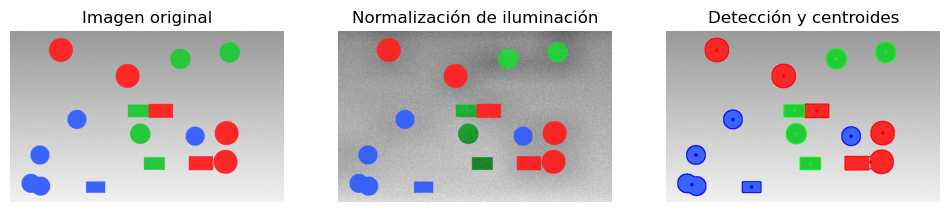

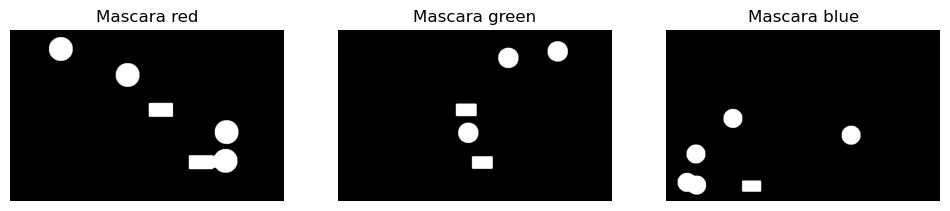

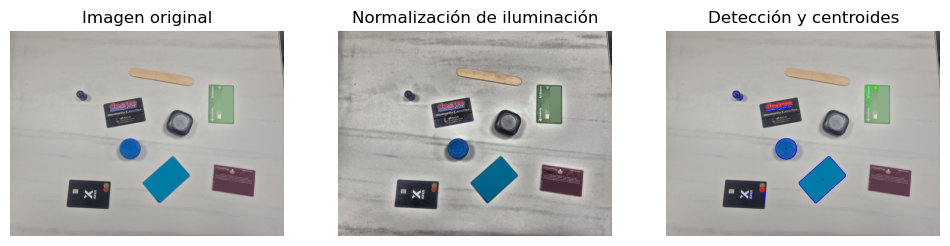

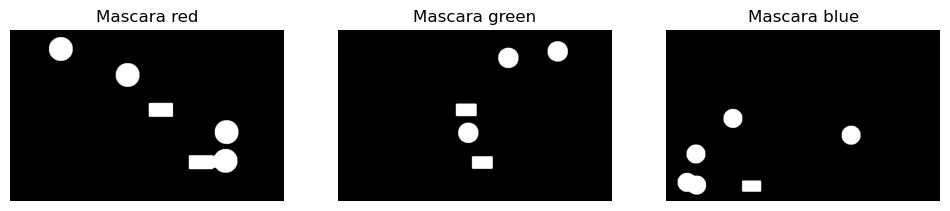

Conteo por color: {'red': 5, 'green': 5, 'blue': 5}
Centroides por color (y, x):
  red: [(np.float64(55.0), np.float64(148.0)), (np.float64(131.0), np.float64(343.0)), (np.float64(233.0), np.float64(440.0)), (np.float64(298.0), np.float64(632.0)), (np.float64(383.8), np.float64(598.0))]
  green: [(np.float64(62.0), np.float64(641.0)), (np.float64(81.0), np.float64(497.0)), (np.float64(233.0), np.float64(374.0)), (np.float64(300.0), np.float64(380.0)), (np.float64(387.0), np.float64(421.0))]
  blue: [(np.float64(258.0), np.float64(195.0)), (np.float64(307.0), np.float64(540.0)), (np.float64(362.0), np.float64(87.0)), (np.float64(449.0), np.float64(75.0)), (np.float64(456.0), np.float64(249.5))]


In [20]:
def _normalize_illumination_hsv(img_rgb):
    """Light normalization: CLAHE on V channel (robust to varying lighting)."""
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    v_eq = clahe.apply(v)
    hsv_eq = cv2.merge([h, s, v_eq])
    img_eq_bgr = cv2.cvtColor(hsv_eq, cv2.COLOR_HSV2BGR)
    img_eq_rgb = cv2.cvtColor(img_eq_bgr, cv2.COLOR_BGR2RGB)
    return img_eq_rgb

def _mask_color_hsv(img_rgb, color):
    """
    Build robust HSV masks for red/green/blue objects.
    Returns a binary mask (uint8 0/1).
    """
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    
    # Define HSV bounds (OpenCV HSV: H:[0,179], S,V:[0,255])
    if color == "red":
        # Red wraps around hue=0, so we combine two ranges
        lower1 = np.array([0,   80, 60], dtype=np.uint8)
        upper1 = np.array([10, 255,255], dtype=np.uint8)
        lower2 = np.array([170, 80, 60], dtype=np.uint8)
        upper2 = np.array([179,255,255], dtype=np.uint8)
        mask1 = cv2.inRange(hsv, lower1, upper1)
        mask2 = cv2.inRange(hsv, lower2, upper2)
        mask = cv2.bitwise_or(mask1, mask2)
    elif color == "green":
        lower = np.array([35,  60, 40], dtype=np.uint8)
        upper = np.array([85, 255,255], dtype=np.uint8)
        mask = cv2.inRange(hsv, lower, upper)
    elif color == "blue":
        lower = np.array([90,  70, 50], dtype=np.uint8)
        upper = np.array([130,255,255], dtype=np.uint8)
        mask = cv2.inRange(hsv, lower, upper)
    else:
        raise ValueError("Unsupported color")
    
    # Morphology to clean noise, fill small holes
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    # Convert to 0/1
    mask_bin = (mask > 0).astype(np.uint8)
    return mask_bin

def detectar_objetos_por_color(imagen):
    """
    Detecta y clasifica objetos por color (rojo, verde, azul).
    Retorna:
      - counts: dict con conteo por color
      - centroids: dict color -> lista de (y, x)
      - masks: dict color -> mascara binaria (0/1)
      - overlay: imagen con contornos y centroides dibujados
    """
    # 1) Normalización de iluminación para robustez
    img_norm = _normalize_illumination_hsv(imagen)
    
    # 2) Máscaras por color
    masks = {}
    for c in ["red", "green", "blue"]:
        masks[c] = _mask_color_hsv(img_norm, c)
    
    # 3) Etiquetado y centroides por color
    counts = {}
    centroids = {}
    overlay = imagen.copy()
    for c, m in masks.items():
        # Etiquetar
        labeled = measure.label(m, connectivity=2)
        props = measure.regionprops(labeled)
        # Filtrar regiones muy pequeñas (basura)
        props = [p for p in props if p.area >= 150]  # ajustable según tamaño esperado
        counts[c] = len(props)
        centroids[c] = [p.centroid for p in props]  # (row=y, col=x)
        
        # Dibujar contornos y centros en overlay
        # Convert overlay to BGR for OpenCV drawing
        ov_bgr = cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR)
        # Build contour image from mask
        m_uint8 = (m*255).astype(np.uint8)
        contours, _ = cv2.findContours(m_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        color_bgr = {
            "red": (0,0,255),
            "green": (0,255,0),
            "blue": (255,0,0)
        }[c]
        cv2.drawContours(ov_bgr, contours, -1, color_bgr, 2)
        for cy, cx in centroids[c]:
            cv2.circle(ov_bgr, (int(cx), int(cy)), 5, color_bgr, -1)
        overlay = cv2.cvtColor(ov_bgr, cv2.COLOR_BGR2RGB)
    
    return {
        "counts": counts,
        "centroids": centroids,
        "masks": masks,
        "overlay": overlay,
        "img_norm": img_norm
    }

# --- Demo con imagen sintética ---
def make_synthetic_scene(h=500, w=800, seed=7):
    rng = np.random.default_rng(seed)
    img = np.zeros((h, w, 3), dtype=np.uint8) + 220  # fondo claro
    
    # Añadir gradiente de iluminación
    y = np.linspace(0.7, 1.1, h).reshape(-1,1,1)
    img = (img.astype(np.float32) * y).clip(0,255).astype(np.uint8)
    
    # Dibujar objetos de colores (círculos y rectángulos)
    def rand_pos(r=40):
        return rng.integers(r+10, h-r-10), rng.integers(r+10, w-r-10)
    
    colors = {
        "red": (255, 40, 40),
        "green": (40, 200, 60),
        "blue": (60, 100, 255),
    }
    # círculos
    for _ in range(4):
        cy, cx = rand_pos(35)
        cv2.circle(img, (cx, cy), 35, colors["red"], -1)
    for _ in range(3):
        cy, cx = rand_pos(30)
        cv2.circle(img, (cx, cy), 30, colors["green"], -1)
    for _ in range(5):
        cy, cx = rand_pos(28)
        cv2.circle(img, (cx, cy), 28, colors["blue"], -1)
    
    # rectángulos
    for _ in range(2):
        y0, x0 = rand_pos(20)
        cv2.rectangle(img, (x0, y0), (x0+70, y0+40), colors["red"], -1)
    for _ in range(2):
        y0, x0 = rand_pos(18)
        cv2.rectangle(img, (x0, y0), (x0+60, y0+36), colors["green"], -1)
    for _ in range(1):
        y0, x0 = rand_pos(16)
        cv2.rectangle(img, (x0, y0), (x0+55, y0+32), colors["blue"], -1)
    
    # Ruido leve
    noise = rng.normal(0, 7, img.shape).astype(np.int16)
    noisy = np.clip(img.astype(np.int16)+noise, 0, 255).astype(np.uint8)
    return noisy

synthetic = make_synthetic_scene(seed = random)
result = detectar_objetos_por_color(synthetic)

img = io.imread('image1.jpg')
result2 = detectar_objetos_por_color(img)

counts = result["counts"]
centroids = result["centroids"]

# Visualización
plt.figure(figsize=(12, 10))
plt.subplot(1,3,1); plt.title("Imagen original"); plt.imshow(synthetic); plt.axis("off")
plt.subplot(1,3,2); plt.title("Normalización de iluminación"); plt.imshow(result["img_norm"]); plt.axis("off")
plt.subplot(1,3,3); plt.title("Detección y centroides"); plt.imshow(result["overlay"]); plt.axis("off")

# Mostrar máscaras individuales
plt.figure(figsize=(12,8))
for i, c in enumerate(["red","green","blue"], start=1):
    plt.subplot(1,3,i)
    plt.title(f"Mascara {c}")
    plt.imshow(result["masks"][c], cmap="gray")
    plt.axis("off")
plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(1,3,1); plt.title("Imagen original"); plt.imshow(img); plt.axis("off")
plt.subplot(1,3,2); plt.title("Normalización de iluminación"); plt.imshow(result2["img_norm"]); plt.axis("off")
plt.subplot(1,3,3); plt.title("Detección y centroides"); plt.imshow(result2["overlay"]); plt.axis("off")

# Mostrar máscaras individuales
plt.figure(figsize=(12,8))
for i, c in enumerate(["red","green","blue"], start=1):
    plt.subplot(1,3,i)
    plt.title(f"Mascara {c}")
    plt.imshow(result["masks"][c], cmap="gray")
    plt.axis("off")
plt.show()

print("Conteo por color:", counts)
print("Centroides por color (y, x):")
for c in ["red","green","blue"]:
    print(f"  {c}: {[(round(y,1), round(x,1)) for y,x in centroids[c]]}")


## Ejercicio 2: Navegación por Líneas (Seguimiento de Trayectoria)




**Escenario**: Un robot móvil debe seguir una línea en el suelo para navegar.

**Tareas**:

1. Detecta líneas usando la transformada de Hough
2. Calcula el ángulo de la línea principal
3. Determina si el robot debe girar izquierda/derecha
4. Estima la distancia al centro de la línea

```python
def seguir_linea(imagen):
    """
    Procesa imagen para seguimiento de línea
    Retorna: ángulo_giro, distancia_centro
    """
    # Preprocesamiento
    gray = rgb2gray(imagen)

    # Detección de bordes
    edges = canny(gray, sigma=2, low_threshold=0.1, high_threshold=0.2)

    # Tu código para Hough Transform aquí

    return angulo_giro, distancia_centro
```

**Reto adicional**: Maneja intersecciones y bifurcaciones.

---


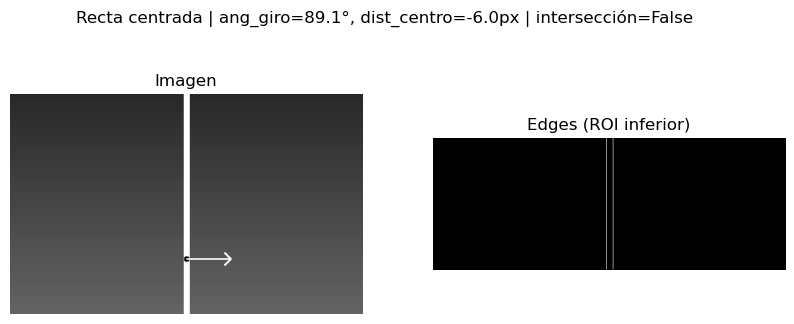

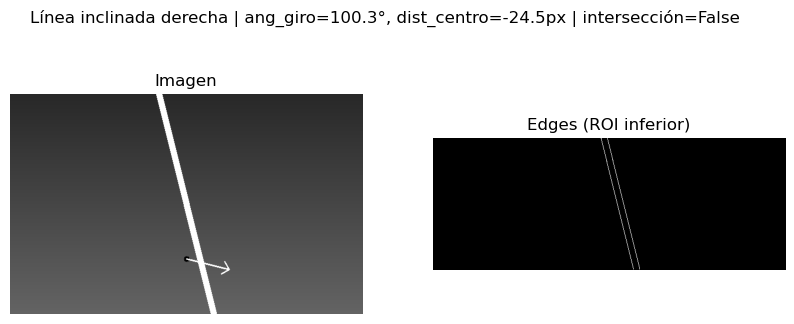

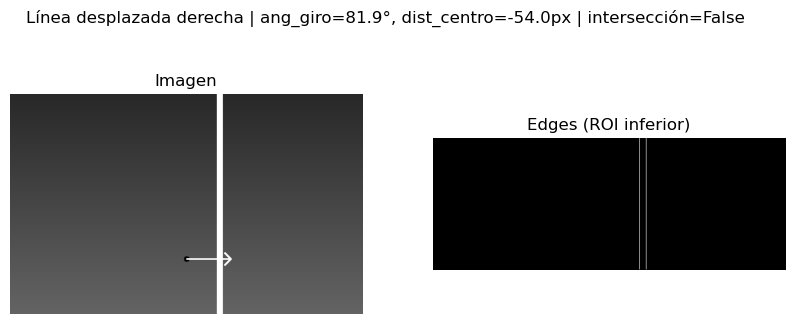

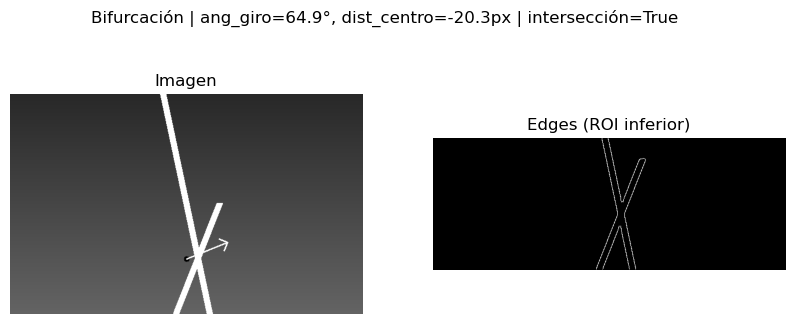

Recta centrada           -> ang_giro= 89.10 deg, dist_centro=  -6.00 px, intersección=False
Línea inclinada derecha  -> ang_giro=100.32 deg, dist_centro= -24.54 px, intersección=False
Línea desplazada derecha -> ang_giro= 81.90 deg, dist_centro= -54.00 px, intersección=False
Bifurcación              -> ang_giro= 64.95 deg, dist_centro= -20.35 px, intersección=True


In [21]:
# Implement 'seguir_linea' using Hough transform and demo on synthetic frames.
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks
import cv2

def _bottom_roi(img, height_ratio=0.5):
    h = img.shape[0]
    y0 = int(h*(1.0-height_ratio))
    return img[y0:], y0

def _line_distance_from_center(rho, theta, cx, cy):
    # Distance from point (cx,cy) to line n·x = rho, where n=(cosθ, sinθ)
    return (cx*np.cos(theta) + cy*np.sin(theta) - rho)

def seguir_linea(imagen):
    """
    Procesa imagen para seguimiento de línea con Hough clásico.
    Convenciones:
      - Cámara mirando hacia delante, eje Y hacia abajo.
      - angulo_giro (deg): giro recomendado; + = girar a la derecha, - = izquierda.
      - distancia_centro (px): offset lateral respecto al centro de la imagen; + = línea a la derecha.
    Retorna: angulo_giro, distancia_centro, extras(dict)
    """
    gray = rgb2gray(imagen)
    # ROI inferior para estabilidad
    roi, y_offset = _bottom_roi(gray, height_ratio=0.6)
    edges = canny(roi, sigma=2.0, low_threshold=0.1, high_threshold=0.25)
    
    # Hough
    hspace, angles, dists = hough_line(edges)
    accums, thetas, rhos = hough_line_peaks(hspace, angles, dists, num_peaks=5, threshold=None)
    
    h, w = imagen.shape[:2]
    cx, cy = w/2.0, (y_offset + roi.shape[0]/2.0)
    
    if len(thetas) == 0:
        # No line found: return zeros and mark lost
        return 0.0, 0.0, {"status": "no_line", "edges": edges, "roi_y0": y_offset}
    
    # Seleccionar línea principal con criterio combinado:
    # 1) más vertical (dirección cercana a 90°), 2) menor distancia al centro, ponderado por acumulador.
    candidates = []
    for a, r, A in zip(thetas, rhos, accums):
        # dirección de la línea (radians) = a - pi/2; vertical => |phi| pequeño (en referencia a eje Y)
        phi = a - np.pi/2.0
        verticality = 1.0 - min(abs(np.rad2deg(phi))/90.0, 1.0)  # 1 = muy vertical
        d = _line_distance_from_center(r, a, cx, cy - y_offset)  # usar coords relativas al ROI
        score = 0.55*verticality + 0.25*(1.0/(1.0+abs(d))) + 0.20*(A/accums.max())
        candidates.append((score, a, r, d))
    candidates.sort(reverse=True, key=lambda x: x[0])
    best_score, theta, rho, dist = candidates[0]
    
    # Ángulo de giro: línea direction phi = theta - pi/2 (radians).
    phi = theta - np.pi/2.0
    phi_deg = np.rad2deg(phi)
    # Política de control sencilla: combinar orientación y offset lateral.
    # Girar a la derecha si la línea está inclinada hacia derecha o está a la derecha del centro (dist>0).
    k_angle = 1.0
    k_offset = 0.15  # px a grados (heurístico)
    angulo_giro = k_angle * (-phi_deg) + k_offset * (dist)  # convención + = derecha
    
    # Distancia (px) con signo según línea a la derecha (+) o izquierda (-)
    distancia_centro = dist
    
    # Detección simple de intersección/bifurcación: múltiples picos con ángulos separados > 25° y buena potencia
    interseccion = False
    if len(thetas) >= 2:
        # normalizar grados [-90,90] para diferencias
        degs = np.rad2deg(thetas)
        degs = ((degs + 180) % 180) - 90
        degs.sort()
        # Si hay una gran separación angular y ambos con acumulador > 50% del máximo, marcar intersección
        Amax = accums.max()
        strong = [A for A in accums if A > 0.5*Amax]
        if len(strong) >= 2 and np.ptp(degs) > 25:
            interseccion = True
    
    extras = {
        "status": "ok",
        "edges": edges,
        "theta": theta,
        "rho": rho,
        "phi_deg": phi_deg,
        "roi_y0": y_offset,
        "interseccion": interseccion
    }
    return float(angulo_giro), float(distancia_centro), extras

# --- Demo con escenas sintéticas ---
def draw_lane(width=640, height=400, line_x=320, slope_deg=10, thickness=10, fork=False, noise=0.0, seed=0):
    """Crea imagen sintética con una línea principal y opcional bifurcación."""
    rng = np.random.default_rng(seed)
    img = np.zeros((height, width, 3), dtype=np.uint8)
    # Fondo con gradiente leve
    for y in range(height):
        val = 40 + int(60*y/height)
        img[y,:,:] = (val,val,val)
    # Línea principal como recta
    slope = np.tan(np.deg2rad(slope_deg))  # dx/dy
    # dibujar generando puntos (y, x=y*slope+line_x)
    pts = []
    for y in range(0, height):
        x = int(line_x + (y - height//2) * slope * 1.0)
        pts.append((x,y))
    for (x,y) in pts:
        cv2.line(img, (x-thickness//2, y), (x+thickness//2, y), (220,220,220), 1)
        cv2.rectangle(img, (x-thickness//2, y-1), (x+thickness//2, y+1), (255,255,255), -1)
    # Bifurcación (segunda línea con otro ángulo, desde mitad inferior)
    if fork:
        slope2 = np.tan(np.deg2rad(-slope_deg*1.8))  # otro sentido
        for y in range(height//2, height):
            x = int(line_x + (y - height//2) * slope2 * 1.0 + 60)
            cv2.rectangle(img, (x-thickness//2, y-1), (x+thickness//2, y+1), (255,255,255), -1)
    # Ruido leve
    if noise>0:
        n = rng.normal(0, noise, img.shape).astype(np.int16)
        img = np.clip(img.astype(np.int16)+n, 0, 255).astype(np.uint8)
    return img

scenes = [
    ("Recta centrada", draw_lane(line_x=320, slope_deg=0)),
    ("Línea inclinada derecha", draw_lane(line_x=320, slope_deg=14)),
    ("Línea desplazada derecha", draw_lane(line_x=380, slope_deg=0)),
    ("Bifurcación", draw_lane(line_x=320, slope_deg=12, fork=True)),
]

results = []
for name, img in scenes:
    ang, dist, ex = seguir_linea(img)
    results.append((name, ang, dist, ex, img))

# Visualización de resultados
for name, ang, dist, ex, img in results:
    edges = ex["edges"]
    roi_y0 = ex["roi_y0"]
    vis = img.copy()
    # Dibuja centro imagen
    h,w = vis.shape[:2]
    cx, cy = int(w/2), int(h*0.75)
    cv2.circle(vis, (cx, cy), 5, (0,0,0), -1)
    # Dibuja orientación estimada en el punto centro inferior
    length = 80
    heading = -np.deg2rad(ex["phi_deg"])  # orientación sugerida (inversa a phi)
    x2 = int(cx + length*np.sin(heading))
    y2 = int(cy - length*np.cos(heading))
    cv2.arrowedLine(vis, (cx, cy), (x2, y2), (255,255,255), 2, tipLength=0.2)
    plt.figure(figsize=(10,4))
    plt.suptitle(f"{name} | ang_giro={ang:.1f}°, dist_centro={dist:.1f}px | intersección={ex['interseccion']}")
    plt.subplot(1,2,1); plt.title("Imagen"); plt.imshow(vis); plt.axis("off")
    plt.subplot(1,2,2); plt.title("Edges (ROI inferior)"); plt.imshow(edges, cmap="gray"); plt.axis("off")
    plt.show()

# Imprimir números
for name, ang, dist, ex, img in results:
    print(f"{name:24s} -> ang_giro={ang:6.2f} deg, dist_centro={dist:7.2f} px, intersección={ex['interseccion']}")


**Escenario**: Un robot debe clasificar y manipular objetos según su forma.

**Tareas**:

1. Detecta contornos de objetos
2. Clasifica formas: círculo, cuadrado, triángulo, rectángulo
3. Calcula orientación para agarre robótico
4. Determina puntos de agarre óptimos

```python
def clasificar_formas(imagen):
    """
    Clasifica objetos por su forma geométrica
    """
    # Detección de contornos
    gray = rgb2gray(imagen)
    edges = canny(gray, sigma=1)

    # Análisis de forma
    contours = measure.find_contours(edges, 0.5)

    formas_detectadas = []

    for contour in contours:
        # Tu código para clasificación aquí
        # Usa aproximación poligonal, análisis de curvatura, etc.
        pass

    return formas_detectadas
```

**Algoritmos sugeridos**:

- Aproximación de Douglas-Peucker
- Análisis de momentos de Hu
- Descriptores de Fourier

---


## Ejercicio 3: Detección y Medición de Objetos (Control de Calidad)

**Escenario**: Un robot industrial debe medir dimensiones de piezas manufacturadas.

**Tareas**:

1. Segmenta objetos del fondo
2. Calcula área, perímetro y dimensiones principales
3. Detecta defectos (agujeros, irregularidades)
4. Clasifica piezas como "aprobadas" o "defectuosas"

```python
def control_calidad(imagen, tolerancia_area=0.1):
    """
    Analiza piezas para control de calidad
    """
    # Segmentación
    gray = rgb2gray(imagen)
    thresh = filters.threshold_otsu(gray)
    binary = gray > thresh

    # Análisis morfológico
    cleaned = morphology.remove_small_objects(binary, min_size=100)

    # Tu código para mediciones aquí

    return resultados_medicion
```

**Métricas a calcular**:

- Área en píxeles y mm²
- Relación aspecto (largo/ancho)
- Circularidad: 4π×área/perímetro²
- Número de agujeros

---


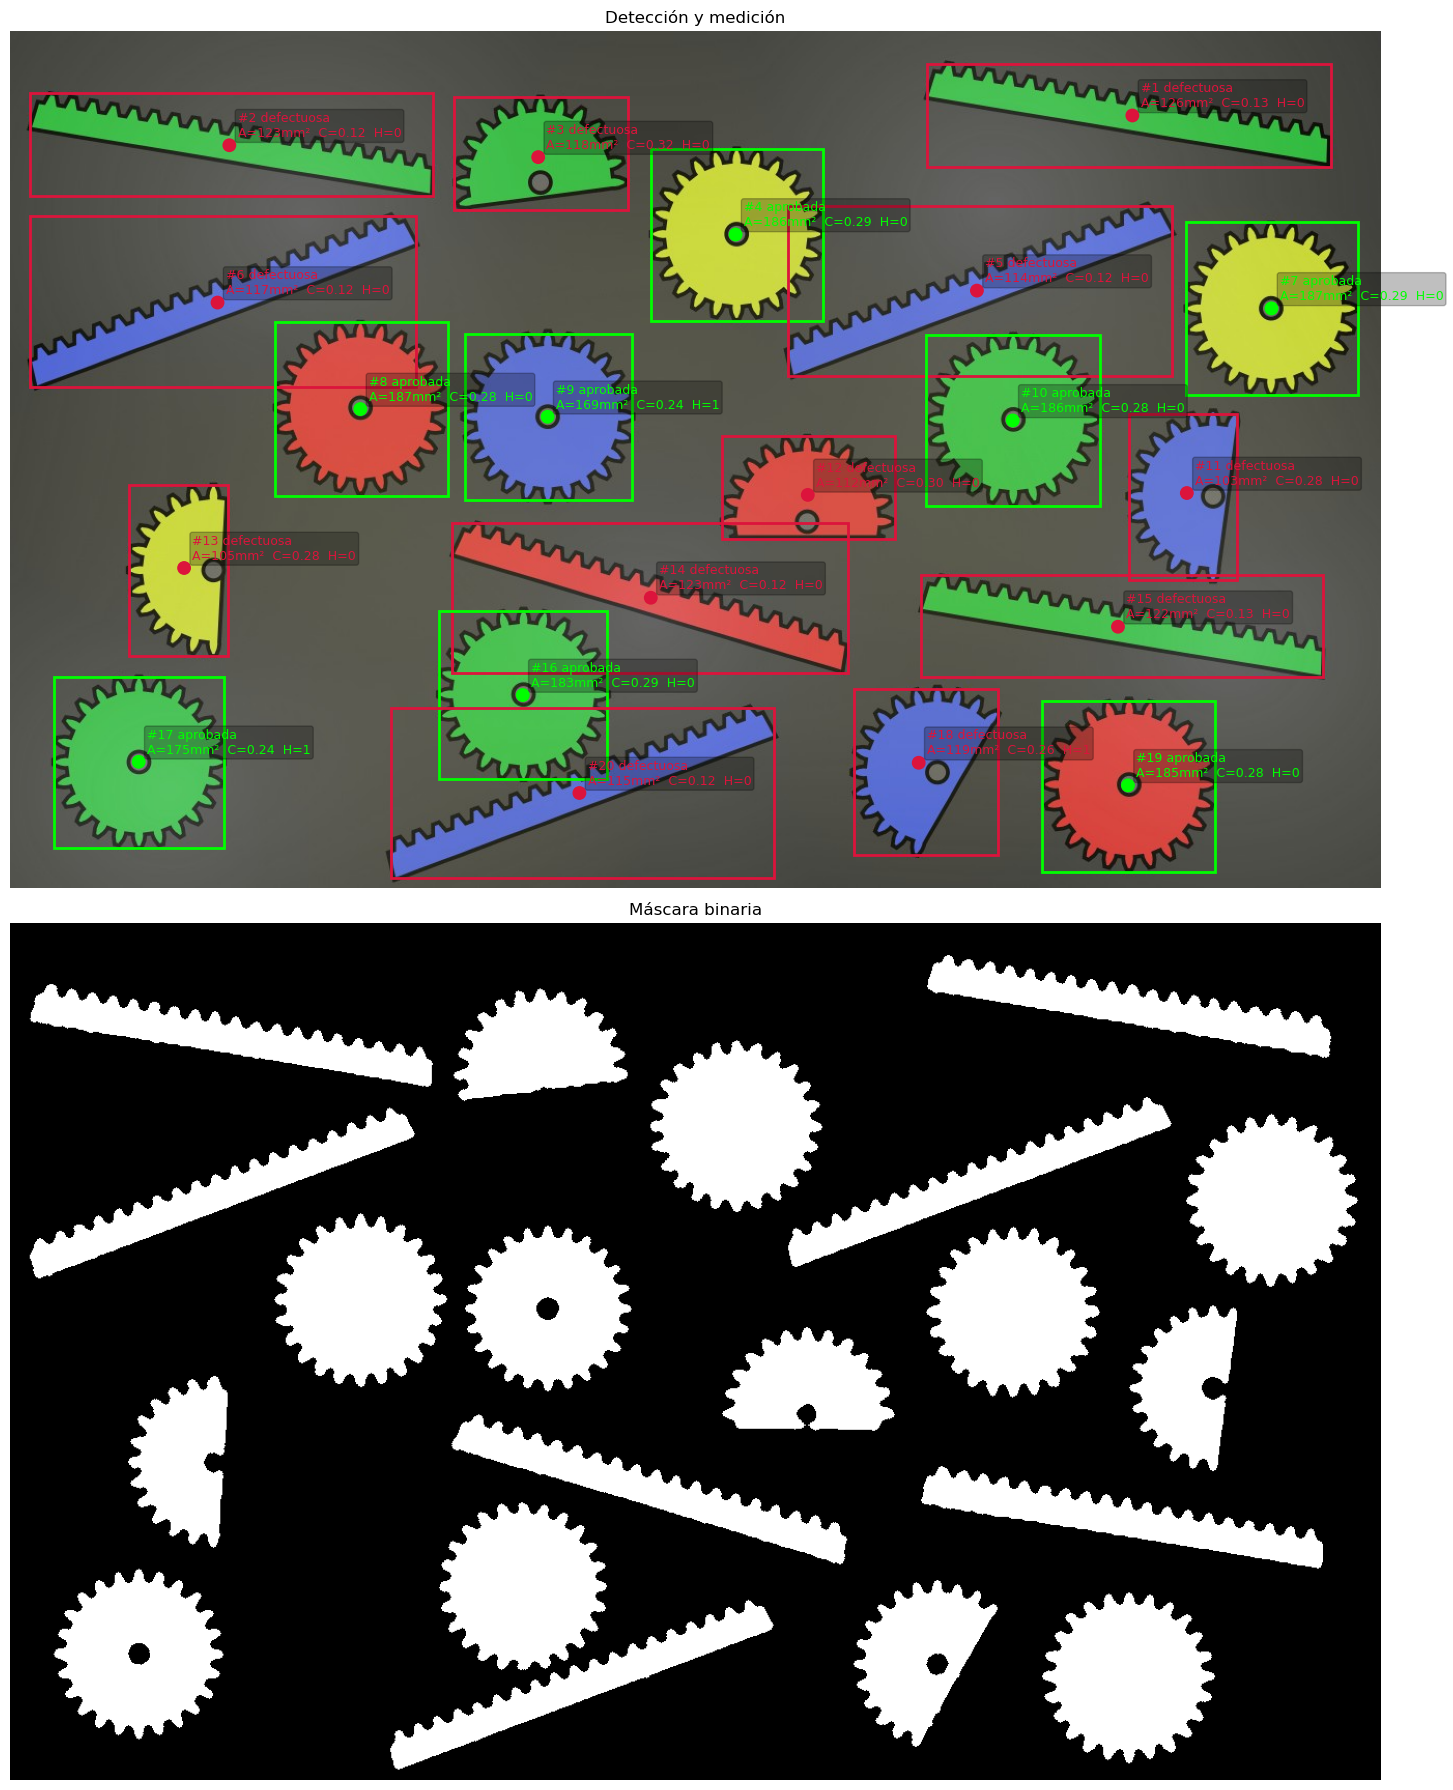

In [22]:
import numpy as np
from skimage import io, measure, morphology
from skimage.color import rgb2hsv, rgba2rgb
from skimage.filters import threshold_otsu
from scipy import ndimage as ndi

def control_calidad(
    imagen,
    mm_por_px=0.10,             # calibra según tu setup (mm por pixel)
    area_nominal_mm2=165.0,     # área correcta
    tolerancia_area=0.20,       # ±20% -> rechaza ~100 mm²
    s_min=None,                 # si None, se calcula automático
    min_area_px=700,            # filtra polvo
    se_radius=3,
    min_circularidad=0.20,
    min_solidez=0.75,
    max_agujeros=2,
):
    """Devuelve (resultados, mascara_binaria)"""

    # --- a) Normalización e HSV ---
    img = imagen
    if img.dtype != np.float32 and img.dtype != np.float64:
        img = img.astype(np.float32) / 255.0
    if img.shape[-1] == 4:  # RGBA -> RGB
        img = rgba2rgb(img)
    hsv = rgb2hsv(img)
    H, S, V = hsv[...,0], hsv[...,1], hsv[...,2]

    # --- b) Máscara por saturación (colores “vivos”) y por brillo (objetos claros) ---
    if s_min is None:
        s_otsu = threshold_otsu(S)  # umbral adaptativo
        s_min = max(0.20, 0.9 * s_otsu)
    mask_sat   = S > s_min
    v_otsu     = threshold_otsu(V)
    mask_bright= V > v_otsu
    mask = mask_sat | mask_bright  # <-- clave para incluir rojos/azules

    # --- c) Limpieza morfológica ---
    se = morphology.disk(se_radius)
    mask = morphology.binary_opening(mask, se)
    mask = morphology.binary_closing(mask, se)
    mask = morphology.remove_small_objects(mask, min_size=min_area_px)
    mask = morphology.remove_small_holes(mask, area_threshold=300)

    # --- d) Medición por regiones ---
    labeled = measure.label(mask, connectivity=2)
    props = measure.regionprops(labeled)

    resultados = []
    for p in props:
        area_px = p.area
        perim   = max(p.perimeter, 1.0)
        circ    = 4*np.pi*area_px/(perim**2)
        sol     = p.solidity

        # Agujeros dentro de la región (conteo real)
        ri = p.image
        filled = ndi.binary_fill_holes(ri)
        holes_mask = filled ^ ri
        holes_labeled = measure.label(holes_mask)
        # cuenta agujeros “reales” (descarta micro-poros)
        num_holes = sum(r.area > 20 for r in measure.regionprops(holes_labeled))

        # Área en mm²
        area_mm2 = (area_px * (mm_por_px**2))

        ok_area = abs(area_mm2 - area_nominal_mm2) <= area_nominal_mm2 * tolerancia_area
        ok_forma = (circ >= min_circularidad) and (sol >= min_solidez)
        ok_holes = (num_holes <= max_agujeros)

        clas = "aprobada" if (ok_area and ok_forma and ok_holes) else "defectuosa"

        resultados.append({
            "label": p.label,
            "bbox": p.bbox,
            "centroide_px": p.centroid,     # (y, x)
            "area_px": area_px,
            "area_mm2": area_mm2,
            "circularidad": float(circ),
            "solidez": float(sol),
            "num_agujeros": int(num_holes),
            "clasificacion": clas,
        })

    return resultados, mask

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle, Circle
from skimage import measure

img = io.imread('image4.jpg')   # usa tu archivo

resultados, mascara = control_calidad(
    img,
    mm_por_px=0.10,
    area_nominal_mm2=165.0,
    tolerancia_area=0.20,   # baja tolerancia → ya no aprueba áreas ~100
)

# ---- Visualización arriba/abajo ----
labeled = measure.label(mascara, connectivity=2)
props_map = {p.label: p for p in measure.regionprops(labeled)}

fig, ax = plt.subplots(2, 1, figsize=(16, 18))
ax[0].imshow(img); ax[0].set_title("Detección y medición"); ax[0].axis("off")
for r in resultados:
    p = props_map.get(r["label"]); 
    if p is None: continue
    color = "lime" if r["clasificacion"] == "aprobada" else "crimson"
    minr, minc, maxr, maxc = p.bbox
    ax[0].add_patch(Rectangle((minc, minr), maxc-minc, maxr-minr, fill=False, lw=2, ec=color))
    y, x = r["centroide_px"]
    ax[0].add_patch(Circle((x, y), radius=6, ec=color, fc=color))
    ax[0].text(x+8, y-8, f"#{r['label']} {r['clasificacion']}\nA={r['area_mm2']:.0f}mm²  C={r['circularidad']:.2f}  H={r['num_agujeros']}",
               color=color, fontsize=9, bbox=dict(boxstyle="round,pad=0.2", fc="black", alpha=0.25))

ax[1].imshow(mascara, cmap="gray"); ax[1].set_title("Máscara binaria"); ax[1].axis("off")
plt.tight_layout(); plt.show()



## Ejercicio 4: Reconocimiento de Formas Geométricas



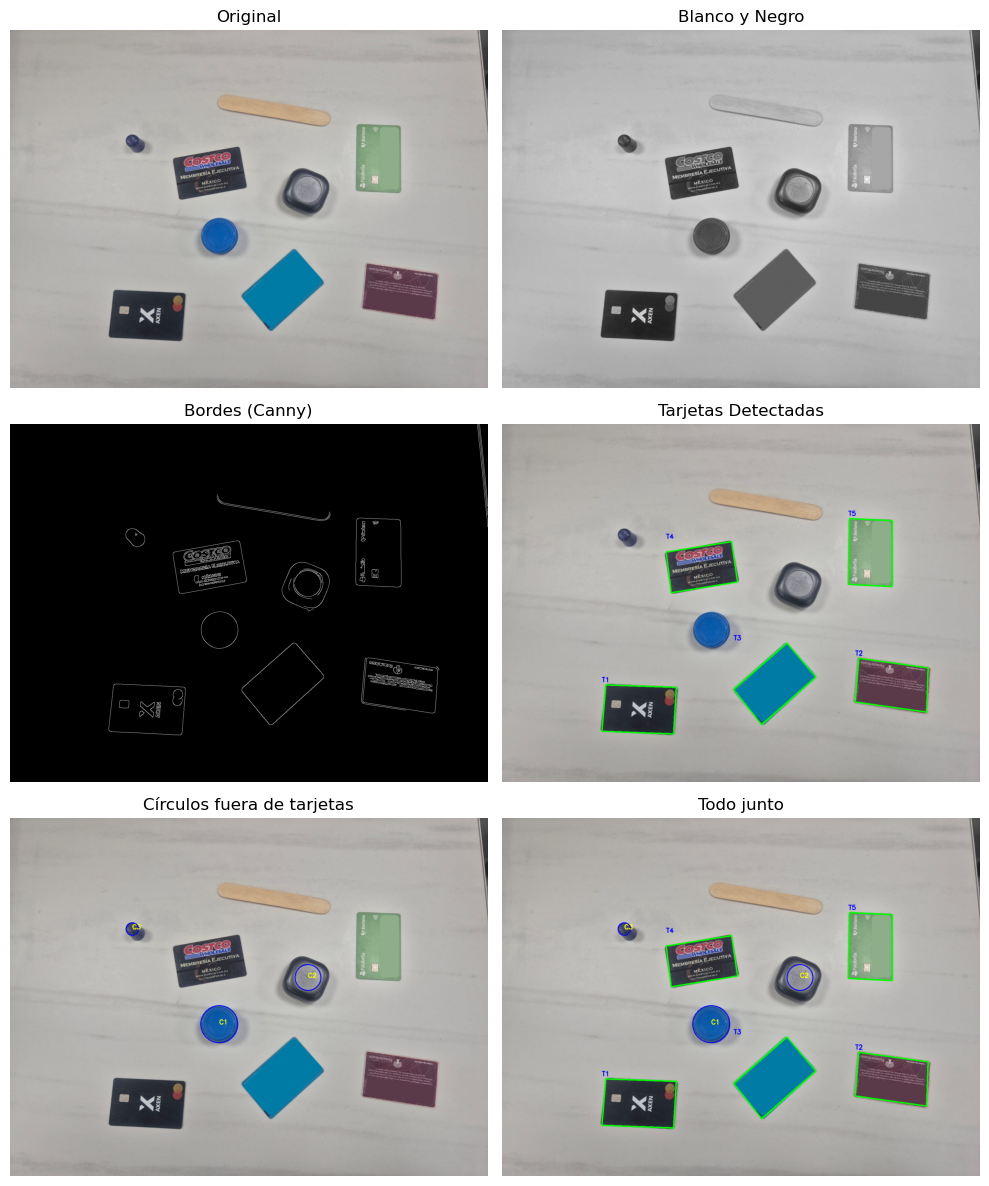

Círculos detectados fuera de tarjetas (x, y, r):
  C1: x=700, y=692, r=62
  C2: x=997, y=536, r=43
  C3: x=409, y=374, r=21


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import cv2

# --------------------------
# Detectar TARJETAS (rectángulos)
# --------------------------
def detectar_tarjetas_cv(imagen):
    """
    Detecta tarjetas (cuadriláteros) con Canny + contornos.
    Devuelve una lista de contornos (cada uno Nx1x2, int32).
    """
    img_cv = cv2.cvtColor(imagen, cv2.COLOR_RGB2BGR)
    gray  = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
    blur  = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    tarjetas = []
    for cnt in contours:
        epsilon = 0.02 * cv2.arcLength(cnt, True)
        approx  = cv2.approxPolyDP(cnt, epsilon, True)  # Nx1x2
        if len(approx) == 4 and cv2.contourArea(approx) > 1000:
            tarjetas.append(approx.astype(np.int32))
    return tarjetas, edges

# --------------------------
# Detectar CÍRCULOS fuera de tarjetas
# --------------------------
def detectar_circulos_fuera_de_tarjetas(imagen, tarjetas,
                                        dp=1.2, minDist=60,
                                        param1=50, param2=45,
                                        minRadius=20, maxRadius=80):
    """
    Detecta círculos con Hough y regresa SOLO los que NO están dentro de ninguna tarjeta.
    Devuelve lista de (x, y, r) enteros.
    """
    img_cv = cv2.cvtColor(imagen, cv2.COLOR_RGB2BGR)
    gray   = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
    blur   = cv2.GaussianBlur(gray, (7, 7), 2)

    circles = cv2.HoughCircles(
        blur, cv2.HOUGH_GRADIENT, dp=dp, minDist=minDist,
        param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius
    )

    puntos = []
    if circles is not None:
        circles = np.around(circles[0]).astype(int)  # (N,3) -> int
        for (x, y, r) in circles:
            # Checar si (x,y) cae dentro de alguna tarjeta
            dentro = False
            for cont in tarjetas:
                # cont: Nx1x2; pointPolygonTest espera contorno Nx1x2
                if cv2.pointPolygonTest(cont, (float(x), float(y)), False) >= 0:
                    dentro = True
                    break
            if not dentro:
                puntos.append((x, y, int(r)))
    return puntos

# --------------------------
# Dibujo utilitario
# --------------------------
def dibujar_tarjetas(imagen, tarjetas, color=(0, 255, 0), thickness=3):
    img_out = cv2.cvtColor(imagen.copy(), cv2.COLOR_RGB2BGR)  # para dibujar en BGR
    for i, cont in enumerate(tarjetas):
        cv2.polylines(img_out, [cont], True, color, thickness)
        x, y, w, h = cv2.boundingRect(cont)
        cv2.putText(img_out, f"T{i+1}", (x, max(y-10, 0)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    return cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB)

def dibujar_circulos(imagen, circulos, color=(255, 0, 0), thickness=2):
    img_out = cv2.cvtColor(imagen.copy(), cv2.COLOR_RGB2BGR)
    for j, (x, y, r) in enumerate(circulos):
        cv2.circle(img_out, (x, y), r, color, thickness)
        cv2.putText(img_out, f"C{j+1}", (x, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
    return cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB)

# --------------------------
# MAIN
# --------------------------
# Carga tu imagen
img = io.imread('image1.jpg')  # Cambia la ruta si es necesario

# 1) Tarjetas
tarjetas, edges = detectar_tarjetas_cv(img)

# 2) Círculos fuera de tarjetas
puntos_circulos = detectar_circulos_fuera_de_tarjetas(img, tarjetas)

# 3) Imágenes auxiliares para mostrar
img_edges_rgb   = edges  # gris
img_tarjetas    = dibujar_tarjetas(img, tarjetas)
img_circulos    = dibujar_circulos(img, puntos_circulos)

# 4) Combinado: tarjetas + círculos
img_final_bgr = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2BGR)
# dibujar tarjetas
for i, cont in enumerate(tarjetas):
    cv2.polylines(img_final_bgr, [cont], True, (0, 255, 0), 3)
    x, y, w, h = cv2.boundingRect(cont)
    cv2.putText(img_final_bgr, f"T{i+1}", (x, max(y-10, 0)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
# dibujar círculos fuera
for j, (x, y, r) in enumerate(puntos_circulos):
    cv2.circle(img_final_bgr, (x, y), r, (255, 0, 0), 2)
    cv2.putText(img_final_bgr, f"C{j+1}", (x, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
img_final = cv2.cvtColor(img_final_bgr, cv2.COLOR_BGR2RGB)

# 5) Mostrar
plt.figure(figsize=(10,12))

plt.subplot(3, 2, 1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

plt.subplot(3, 2, 2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cmap='gray')
plt.title('Blanco y Negro')
plt.axis('off')

plt.subplot(3, 2, 3)
plt.imshow(edges, cmap='gray')
plt.title('Bordes (Canny)')
plt.axis('off')

plt.subplot(3, 2, 4)
plt.imshow(img_tarjetas)
plt.title('Tarjetas Detectadas')
plt.axis('off')

plt.subplot(3, 2, 5)
plt.imshow(img_circulos)
plt.title('Círculos fuera de tarjetas')
plt.axis('off')

plt.subplot(3, 2, 6)
plt.imshow(img_final)
plt.title('Todo junto')
plt.axis('off')

plt.tight_layout()
plt.show()

# 6) (Opcional) imprimir coordenadas
if puntos_circulos:
    print("Círculos detectados fuera de tarjetas (x, y, r):")
    for i, (x, y, r) in enumerate(puntos_circulos, 1):
        print(f"  C{i}: x={x}, y={y}, r={r}")
else:
    print("No se detectaron círculos fuera de tarjetas.")
